In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# import albumentations as A
# from albumentations.pytorch import ToTensorV2
import cv2
import glob
import numpy as np
import time

# Data Prep

In [2]:
TRAIN_PATH = "./data/seg_train/seg_train/"
TEST_PATH = "./data/seg_test/seg_test/"
PRED_PATH = "./data/seg_pred/seg_pred/"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
train_img_path = []
train_labels = []

for path in glob.glob(TRAIN_PATH + "*"):
    train_labels.append(path.split("\\")[-1])
    train_img_path.append(glob.glob(path + "/*"))

test_img_path = []
test_labels = []

for path in glob.glob(TEST_PATH+"*"):
    test_labels.append(path.split("\\")[-1])
    test_img_path.append(glob.glob(path + "/*"))

pred_img_path = []

for path in glob.glob(PRED_PATH+"*"):
    pred_img_path.append(glob.glob(path))

In [4]:
idx_to_class = {i:j for i, j in enumerate(train_labels)}
class_to_idx = {j:i for i, j in idx_to_class.items()}

# convert list to 1d
train_img_path_1D = [item for sublist in train_img_path for item in sublist]
test_img_path_1D = [item for sublist in test_img_path for item in sublist]
pred_img_path_1D = [item for sublist in pred_img_path for item in sublist]

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

class toDataset(Dataset):
    def __init__(self, img_path,transform=None):
        self.img_path = img_path
        self.transform = transform

    def __len__(self):
        return len(self.img_path)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_path[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (120, 120))

        if self.transform is not None:
            img = self.transform(img)

        label = self.img_path[idx].split("\\")[-2]
        label = class_to_idx[label]
        return img, label

In [6]:
train_ds = toDataset(train_img_path_1D, transform)
test_ds = toDataset(test_img_path_1D, transform)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=True)

# Modeling

In [15]:
def get_model():
    model = nn.Sequential(
        nn.Conv2d(3, 128, kernel_size=3),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(128, 256, kernel_size=3, stride=2),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Flatten(),
        nn.Linear(50176, 512),
        nn.ReLU(),
        nn.Linear(512, len(train_labels))
    ).to(DEVICE)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    return model, loss_fn, optimizer, scheduler

def train_batch(x, y, model, loss_fn, optimizer):
    model.train()
    optimizer.zero_grad()
    y_pred = model(x)
    l2 = 0 
    for param in model.parameters():
        l2 += torch.norm(param)
    loss = loss_fn(y_pred, y) + 0.001 * l2
    loss.backward()
    optimizer.step()
    return loss.item()

def acc_eval(x, y, model):
    model.eval()
    y_pred = model(x)
    _, y_pred = torch.max(y_pred, 1)
    return (y_pred == y).float().mean().item()

In [40]:
start = time.time()
EPOCH = 15
model, loss_fn, optimizer, scheduler = get_model()

train_losses = []
train_accs = []
test_losses = []
test_accs = []
for epoch in range(EPOCH):
    batch_train_loss = []
    batch_train_acc = []
    batch_test_loss = []
    batch_test_acc = []
    for x, y in train_dl:
        x, y = x.to(DEVICE), y.to(DEVICE)
        train_loss = train_batch(x, y, model, loss_fn, optimizer)
        batch_train_loss.append(train_loss)

        train_acc = acc_eval(x, y, model)
        batch_train_acc.append(train_acc)
    train_losses.append(np.mean(batch_train_loss))
    train_accs.append(np.mean(batch_train_acc))
    print(f"Epoch {epoch+1}/{EPOCH} | Train Loss: {train_losses[-1]} | Train Acc: {train_accs[-1]}")
    torch.cuda.empty_cache()


    for x, y in test_dl:
        x, y = x.to(DEVICE), y.to(DEVICE)
        model.eval()
        test_loss = loss_fn(model(x), y)
        batch_test_loss.append(test_loss.item())

        test_acc = acc_eval(x, y, model)
        batch_test_acc.append(test_acc)
    test_losses.append(np.mean(batch_test_loss))
    test_accs.append(np.mean(batch_test_acc))
    print(f"Epoch {epoch+1}/{EPOCH} | Test Loss: {test_losses[-1]} | Test Acc: {test_accs[-1]}")
    torch.cuda.empty_cache()

    scheduler.step()

    if(epoch+1)%5 == 0:
        print("=============================")
        torch.save(model, f"./checkpoint/model_{epoch+1}.pth")
        print(f"Model saved at epoch {epoch+1}")

end = time.time()
print(f"Training Time: {(end-start)/60} min")

Epoch 1/15 | Train Loss: 1.7478589696601745 | Train Acc: 0.6146861553735233
Epoch 1/15 | Test Loss: 0.8881783339571445 | Test Acc: 0.6628989361702128
Epoch 2/15 | Train Loss: 0.789694254042619 | Train Acc: 0.75139996198967
Epoch 2/15 | Test Loss: 0.7243304588693253 | Test Acc: 0.7248448583673923
Epoch 3/15 | Train Loss: 0.6822284336513702 | Train Acc: 0.7929163503212375
Epoch 3/15 | Test Loss: 0.5761408086152787 | Test Acc: 0.7926640073035626
Epoch 4/15 | Train Loss: 0.6123086529060485 | Train Acc: 0.8216116173120729
Epoch 4/15 | Test Loss: 0.5787065476179123 | Test Acc: 0.8066267732610094
Epoch 5/15 | Train Loss: 0.5649789849079823 | Train Acc: 0.8433861680888912
Epoch 5/15 | Test Loss: 0.6170466031799925 | Test Acc: 0.788674645601435
Model saved at epoch 5
Epoch 6/15 | Train Loss: 0.4130683821670558 | Train Acc: 0.8881849532518409
Epoch 6/15 | Test Loss: 0.4957971522148619 | Test Acc: 0.8352171987929242
Epoch 7/15 | Train Loss: 0.3858333178085184 | Train Acc: 0.8995032903816814
Epoch

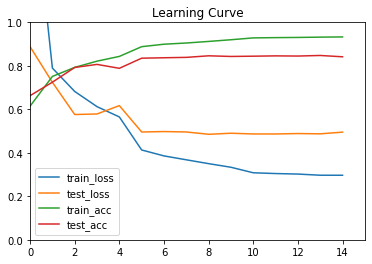

In [43]:
plt.title("Learning Curve")
plt.plot(train_losses, label="train_loss")
plt.plot(test_losses, label="test_loss")
plt.plot(train_accs, label="train_acc")
plt.plot(test_accs, label="test_acc")
plt.axis([0, EPOCH, 0, 1])
plt.legend()

# Evaluation

In [59]:
model_15 = torch.load(f"./checkpoint/model_15.pth")

In [60]:
y_true = []
y_pred = []
for x,y in test_dl:
    y_true.append(y)
    y_pred.append(model_15(x.to(DEVICE)).argmax(dim=1))

In [61]:
y_pred = torch.cat(y_pred).cpu().numpy()
y_true = torch.cat(y_true).cpu().numpy()

In [63]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.78      0.80       437
           1       0.92      0.95      0.94       474
           2       0.83      0.80      0.82       553
           3       0.78      0.83      0.81       525
           4       0.86      0.83      0.84       510
           5       0.84      0.86      0.85       501

    accuracy                           0.84      3000
   macro avg       0.84      0.84      0.84      3000
weighted avg       0.84      0.84      0.84      3000



In [86]:
y_pred_final = []
for pred_path in pred_img_path_1D:
    img = cv2.imread(pred_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (120, 120))
    img = transform(img)
    img = img.unsqueeze(0)
    img = img.to(DEVICE)
    pred = model_15(img).argmax(dim=1).item()
    y_pred_final.append(pred)

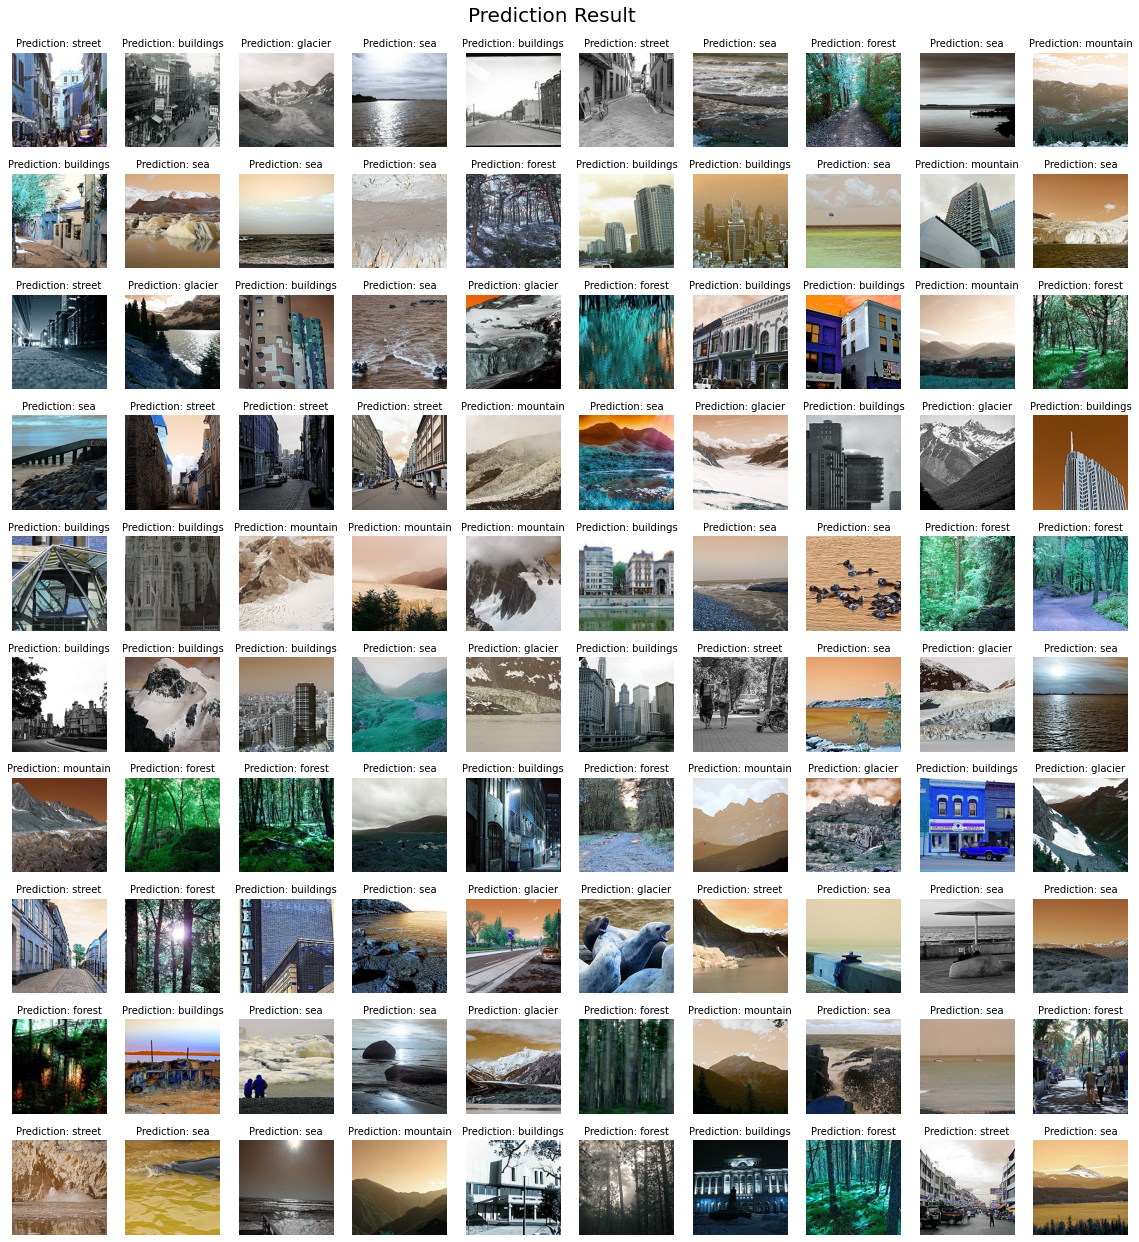

In [153]:
import random

random.seed(42)
fig, ax = plt.subplots(10, 10, figsize=(20, 20))
for i in range(10):
    for j in range(10):
        idx = random.randint(0, len(y_pred_final)-1)
        ax[i][j].imshow(cv2.imread(pred_img_path_1D[idx]))
        ax[i][j].set_title(f"Prediction: {idx_to_class[y_pred_final[idx]]}", fontsize=10)
        ax[i][j].axis('off')

fig.suptitle("Prediction Result", fontsize=20)
fig.subplots_adjust(top=0.95)
plt.show()

# Custom Data

In [151]:
custom_data_path = "./custom_data/"
custom_img_path_1D = glob.glob(custom_data_path + "*.jpeg")
y_custom = []
for path in glob.glob(custom_data_path+"*.jpeg"):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (120, 120))
    img = transform(img)
    img = img.unsqueeze(0)
    img = img.to(DEVICE)
    pred = model_15(img).argmax(dim=1).item()
    y_custom.append(pred)

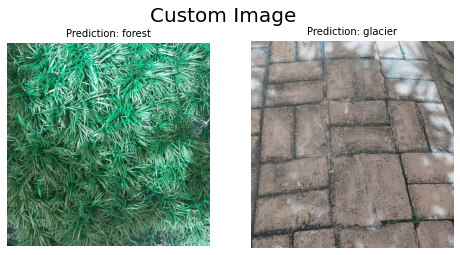

In [152]:
fig, ax = plt.subplots(1, 2, figsize=(8,4))
fig.suptitle("Custom Image", fontsize=20)
ax[0].imshow(cv2.imread(custom_img_path_1D[0]))
ax[0].set_title(f"Prediction: {idx_to_class[y_custom[0]]}", fontsize=10)
ax[0].axis('off')
ax[1].imshow(cv2.imread(custom_img_path_1D[1]))
ax[1].set_title(f"Prediction: {idx_to_class[y_custom[1]]}", fontsize=10)
ax[1].axis('off')
plt.show()